In [1]:
%load_ext autoreload
%autoreload 2

import src.ksd.models as models
from src.ksd.find_modes import find_modes, pairwise_directions, run_bfgs
from src.ksd.langevin import RandomWalkMH, RandomWalkBarker
import src.ksd.langevin as mcmc
from src.ksd.ksd import KSD, SDEKSD
from src.ksd.kernel import IMQ
from src.ksd.bootstrap import Bootstrap
from src.ksd.find_modes import find_modes, pairwise_directions
from tqdm.notebook import tqdm, trange

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import seaborn as sns

import src.kgof.density as density
import src.kgof.data as data

MCMCKernel = RandomWalkMH # RandomWalkBarker 

# BV SDE

In [118]:
tf.random.set_seed(1)

In [119]:
dim = 2

## mixure of gaussians
k = 1
delta = 30.
ratio_sample = 1.
ratio_target = 0.5

target, log_prob_fn = models.create_mixture_gaussian_kdim(
    dim=dim, k=k, delta=delta, return_logprob=True, ratio=ratio_target)
proposal_off, log_prob_off_fn = models.create_mixture_gaussian_kdim(
    dim=dim, k=k, delta=delta, return_logprob=True, ratio=ratio_sample)

## scaled Gaussian 
# ratio_t = 0.5
# ratio_s = 0.3
# target, log_prob_fn = models.create_mixture_gaussian_scaled(ratio=ratio_t, return_logprob=True)
# proposal_off, log_prob_off_fn = models.create_mixture_gaussian_scaled(ratio=ratio_s, return_logprob=True)

In [120]:
n = 1000
samples_on = target.sample(n)
samples_on_df = pd.DataFrame({f"x{i}": samples_on[:, i] for i in range(dim)})
samples_on_df["type"] = "on"

samples_off = proposal_off.sample(n)
samples_off_df = pd.DataFrame({f"x{i}": samples_off[:, i] for i in range(dim)})
samples_off_df["type"] = "off"

samples_df = pd.concat([samples_on_df, samples_off_df], ignore_index=True)

In [121]:
def vp_sde(T, x_init, beta):
    beta = beta*np.ones((T,)) if isinstance(beta, float) else beta.numpy()
    noise = tf.random.normal((T, n, x_init.shape[1])).numpy() # T x n x dim
    
    xt = np.zeros((T+1, n, dim)) # (T+1) x n x dim
    xt[0] = x_init.numpy()
    
    # initialise ksd test
    num_boot = 800
    alpha = 0.05
    nrep = T+1

    kernel = IMQ(med_heuristic=True)
    ksd = KSD(target=target, kernel=kernel)
    
    bootstrap = Bootstrap(ksd, x_init.shape[0])
    multinom_samples = bootstrap.multinom.sample((1, num_boot))
    
    p_vals = []
    ksd_vals = []
    _, p_val = bootstrap.test_once(
        alpha=alpha, num_boot=num_boot, X=tf.constant(xt[0], dtype=tf.float32), 
        multinom_samples=multinom_samples[0],
    )
    p_vals.append(p_val)
    ksd_vals.append(bootstrap.ksd_hat)
    
    ksd = SDEKSD(target=target, kernel=kernel)
    bootstrap = Bootstrap(ksd, x_init.shape[0])
    multinom_samples = bootstrap.multinom.sample((nrep, num_boot))
    
    alpha_t = 1.
    
    for t in trange(T):
        xt[t+1] = tf.math.sqrt(1 - beta[t]) * xt[t] + tf.math.sqrt(beta[t]) * noise[t]
        alpha_t *= (1 - beta[t])
        
        _, p_val = bootstrap.test_once(
            alpha=alpha, 
            num_boot=num_boot, 
            X=tf.constant(xt[t+1], dtype=tf.float32), 
            multinom_samples=multinom_samples[t+1],
            alpha_t=tf.constant(alpha_t, dtype=tf.float32),
            conv_samples=tf.constant(noise[t], dtype=tf.float32), # n x dim
        )
        p_vals.append(p_val)
        ksd_vals.append(bootstrap.ksd_hat)
        
    return xt, p_vals, ksd_vals

In [122]:
T = 100
beta = 0.1

xt_on, pval_on, ksd_on = vp_sde(T=T, x_init=samples_on, beta=beta)
res_df_on = pd.DataFrame({
    "pval": pval_on, 
    "type": ["on"]*len(pval_on),
    "ksd": ksd_on,
    "t": range(len(pval_on))})

  0%|          | 0/100 [00:00<?, ?it/s]

In [123]:
xt_off, pval_off, ksd_off = vp_sde(T=T, x_init=samples_off, beta=beta)
res_df_off = pd.DataFrame({
    "pval": pval_off, 
    "type": ["off"]*len(pval_off),
    "ksd": ksd_off,
    "t": range(len(pval_off))})

  0%|          | 0/100 [00:00<?, ?it/s]

In [124]:
def plot_steps(plot_t_step, xt_on, xt_off, pval_on, pval_off, axis):
    steps = xt_on.shape[0]
    nplots = steps // plot_t_step
    nrows = int(np.sqrt(nplots))
    ncols = int(np.ceil(nplots / nrows))

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*nrows, 3*ncols))
    
    ind = 0
    t = 0
    for row in ax:
        for col in row:
            if ind >= nplots: break
            
            col.scatter(xt_on[t, :, 0], xt_on[t, :, 1], alpha=0.4, label="pval on = {:.3f}".format(pval_on[t]))
            col.scatter(xt_off[t, :, 0], xt_off[t, :, 1], alpha=0.4, label="pval off = {:.3f}".format(pval_off[t]))
            col.axis(xmin=axis[0], xmax=axis[1], ymin=axis[2], ymax=axis[3])
            col.set_title(f"t = {t}")

            col.legend()

            ind += 1
            t += plot_t_step

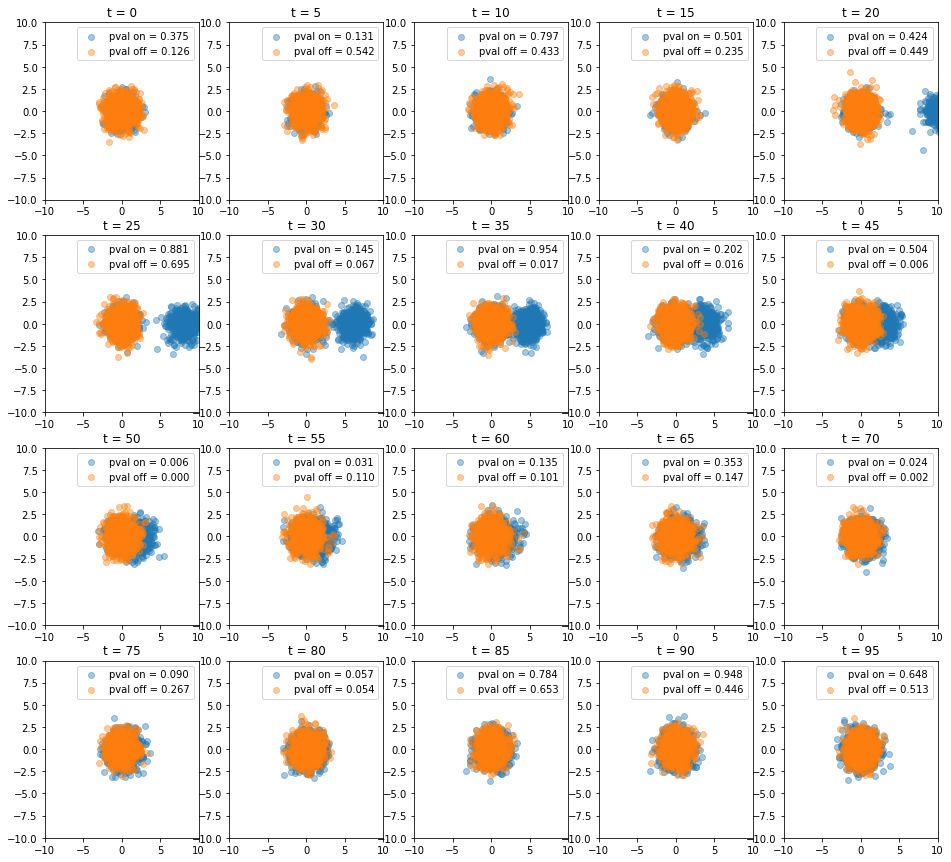

In [127]:
plot_steps(plot_t_step=5, 
           xt_on=xt_on, pval_on=pval_on,
           xt_off=xt_off, pval_off=pval_off,
           axis=[-10., 10., -10., 10.])

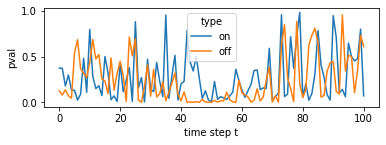

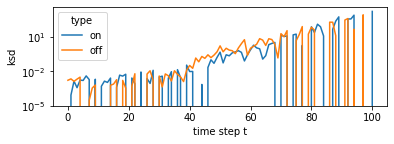

In [134]:
pvals_df = pd.concat([res_df_on, res_df_off], axis=0).reset_index()
plt.subplot(2, 1, 1)
sns.lineplot(data=pvals_df, x="t", y="pval", hue="type")
_ = plt.xlabel("time step t")
plt.show()
plt.subplot(2, 1, 1)
sns.lineplot(data=pvals_df, x="t", y="ksd", hue="type")
_ = plt.xlabel("time step t")
plt.yscale("log")
plt.axis(ymin=1e-5)
plt.show()

In [135]:
pvals_df

,index,pval,type,ksd,t
0,0,0.374532,on,-0.000083,0
1,1,0.370787,on,0.000087,1
2,2,0.178527,on,0.001412,2
3,3,0.298377,on,0.000384,3
4,4,0.134831,on,0.001752,4
...,...,...,...,...,...
197,96,0.500624,off,-195.251299,96
198,97,0.104869,off,881.709998,97
199,98,0.348315,off,-44.420597,98
200,99,0.731586,off,-614.854727,99


# Metropolis-Adjusted Langevin dynamics

In [2]:
tf.random.set_seed(0)

In [3]:
delta = 2.
n = 500
dim = 5

target = create_mixture_gaussian(dim=dim, delta=delta)
one_component_mean = - delta * tf.eye(dim)[:, 0]

proposal_off = tfd.MultivariateNormalDiag(one_component_mean)
# proposal_off = tfd.MultivariateNormalDiag(0.*one_component_mean, 6*tf.ones(dim))
proposal_on = create_mixture_gaussian(dim=dim, delta=delta)

2022-01-17 22:03:50.146726: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-17 22:03:50.724782: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9658 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:db:00.0, compute capability: 7.5


In [4]:
off_samples = proposal_off.sample(n)
on_samples = proposal_on.sample(n)

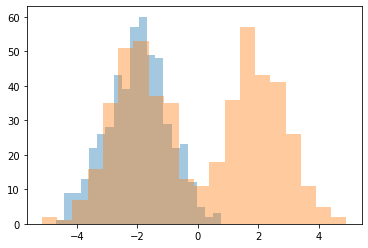

In [5]:
_ = plt.hist(off_samples.numpy()[:, 0], bins=20, label="off-target", alpha=0.4)
_ = plt.hist(on_samples.numpy()[:, 0], bins=20, label="target", alpha=0.4)

In [6]:
def log_prob_fn(x):
    exp1 = tf.reduce_sum((x - one_component_mean)**2, axis=-1) # n
    exp2 = tf.reduce_sum((x + one_component_mean)**2, axis=-1) # n
    return tf.math.log(
        tf.math.exp(- 0.5 * exp1) + tf.math.exp(- 0.5 * exp2)
    )

# def log_prob_fn(x):
#     return proposal_on.log_prob(x)

# mala_off = MALA(log_prob=proposal_on.log_prob)
mala_off = MALA(log_prob=log_prob_fn)

In [7]:
steps = 2000
step_size = 1e-2
x_init_off = tf.identity(off_samples)

mala_off.run(steps=steps, step_size=step_size, x_init=x_init_off)

In [8]:
# check if the hard-coded log_prob equals to the built-in fn
diff = log_prob_fn(x_init_off) - proposal_on.log_prob(x_init_off)
tf.experimental.numpy.allclose(diff, diff[0])

<tf.Tensor: shape=(), dtype=bool, numpy=True>

In [9]:
# import cProfile
# import pstats
# from pstats import SortKey

# cProfile.run('mala_off.run(steps=steps, step_size=step_size, x_init=x_init_off)', 'restats')

# p = pstats.Stats('restats')
# p.strip_dirs().sort_stats("cumtime").print_stats()

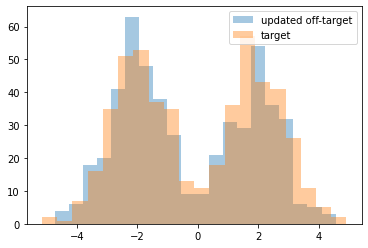

In [10]:
_ = plt.hist(mala_off.x.numpy()[-1, :, 0], bins=20, label="updated off-target", alpha=0.4)
_ = plt.hist(on_samples.numpy()[:, 0], bins=20, label="target", alpha=0.4)
_ = plt.legend()

In [11]:
def plot_steps(plot_t_step, result):
    nplots = steps // plot_t_step
    nrows = int(np.sqrt(nplots))
    ncols = int(np.ceil(nplots / nrows))

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*nrows, 3*ncols))

    ind = 0
    t = 0
    for row in ax:
        for col in row:
            if ind >= nplots: break

            col.hist(result.x.numpy()[t, :, 0], bins=40, label="updated off-target", alpha=0.4)
            col.hist(on_samples.numpy()[:, 0], bins=20, label="target", alpha=0.4)
    #         res_df = pd.DataFrame({"x": result.x.numpy()[t, :, 0], "type": "updated off-target"})
    #         res_df2 = pd.DataFrame({"x": on_samples.numpy()[:, 0], "type": "target"})
    #         res_df = pd.concat([res_df, res_df2], ignore_index=True)
    #         sns.ecdfplot(ax=col, data=res_df, hue="type", x="x", alpha=0.4)
    #         col.legend()
            col.set_title(f"t = {t}")

            if t == 0:
                col.legend()

            ind += 1
            t += plot_t_step

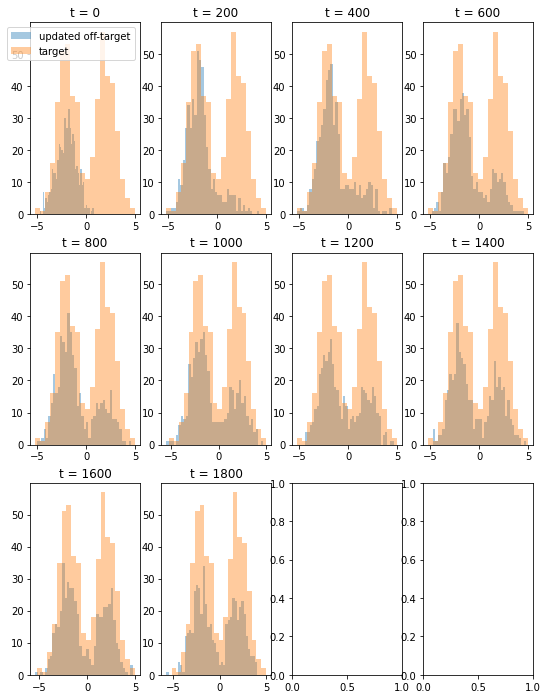

In [13]:
plot_t_step = 200 # plot every xxx steps
plot_steps(plot_t_step=plot_t_step, result=mala_off)

In [14]:
mala_on = MALA(log_prob=log_prob_fn)

x_init_on = tf.identity(on_samples)
mala_on.run(steps=steps, step_size=step_size, x_init=x_init_on)

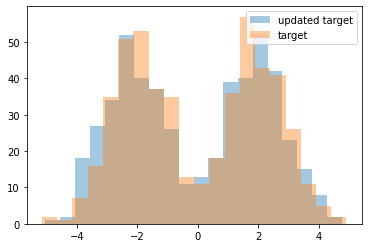

In [15]:
_ = plt.hist(mala_on.x.numpy()[-1, :, 0], bins=20, label="updated target", alpha=0.4)
_ = plt.hist(on_samples.numpy()[:, 0], bins=20, label="target", alpha=0.4)
_ = plt.legend()

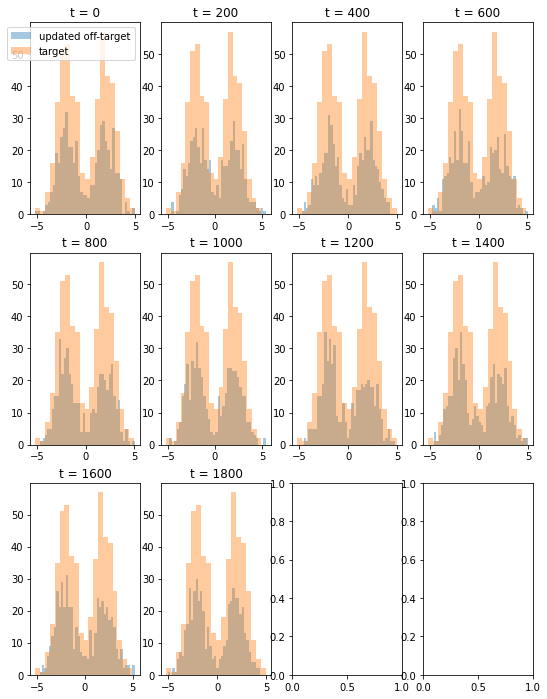

In [16]:
plot_steps(plot_t_step=plot_t_step, result=mala_on)

# KSD as a function of number of steps

In [17]:
from src.ksd.ksd import KSD
from src.ksd.kernel import RBF, IMQ

In [18]:
tf.random.set_seed(0)

In [19]:
kernel = IMQ(med_heuristic=True)

ksd = KSD(target=target, kernel=kernel)

nrep = 10

In [20]:
def run_mala_experiment(nrep, proposal_off, proposal_on, steps, step_size):
    ksd_df = pd.DataFrame(columns=["t", "ksd", "seed", "type"])

    iterator = trange(nrep)
    for seed in iterator:
        off_samples = proposal_off.sample(n)
        on_samples = proposal_on.sample(n)
        
        x_init_off = off_samples
        x_init_on = on_samples

        mala_off = MALA(log_prob=log_prob_fn)
        mala_off.run(steps=steps, step_size=step_size, x_init=x_init_off)

        mala_on = MALA(log_prob=log_prob_fn)
        mala_on.run(steps=steps, step_size=step_size, x_init=x_init_on)

        for t in range(steps):
            iterator.set_description(f"Time step {t+1} of {steps}")

            x_t = mala_off.x[t, :, :].numpy()
            ksd_val = ksd(x_t, tf.identity(x_t)).numpy()
            ksd_df.loc[len(ksd_df)] = [t, ksd_val, seed, "off-target"]
            
            x_t = mala_on.x[t, :, :].numpy()
            ksd_val = ksd(x_t, tf.identity(x_t)).numpy()
            ksd_df.loc[len(ksd_df)] = [t, ksd_val, seed, "target"]
            
    return ksd_df

In [21]:
step_size = 1e-2
steps = 2000
ksd_df = run_mala_experiment(
    nrep=nrep, 
    proposal_off=proposal_off, 
    proposal_on=proposal_on, 
    steps=steps, 
    step_size=step_size)

  0%|          | 0/10 [00:00<?, ?it/s]

In [23]:
# ksd_df = pd.read_csv("res/mala.csv")
ksd_df.to_csv(f"res/mala_{step_size}_delta{delta}.csv", index=False)

<AxesSubplot:xlabel='t', ylabel='ksd'>

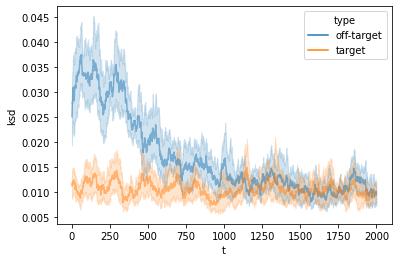

In [22]:
sns.lineplot(data=ksd_df, x="t", y="ksd", hue="type", alpha=0.5)

# Check if the test controls p-value

In [ ]:
from src.ksd.ksd import KSD
from src.ksd.kernel import RBF, IMQ

In [ ]:
tf.random.set_seed(0)

In [ ]:
kernel = IMQ(med_heuristic=True)

ksd = KSD(target=target, kernel=kernel)

nrep = 10